<a href="https://colab.research.google.com/github/stefanogiagu/corso_AML_2024/blob/main/notebooks/es5/AML_2024_HandsOn_5_BNN_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Machine Learning for Physics 2023-24
## Hands-on session 5

Implementation in pytorch of simple Bayesian Neural Network using the library Torchbnn, trained for a regression task

Demo from the [Torchbnn](https://github.com/Harry24k/bayesian-neural-network-pytorch/tree/master) developer with some minor modifications

*Stefano Giagu - v1.0 - 26.3.2024*

In [ ]:
#install torchbnn

!pip install torchbnn

In [ ]:
import numpy as np
from sklearn import datasets

import torch
import torch.nn as nn
import torch.optim as optim

import torchbnn as bnn

import matplotlib.pyplot as plt
%matplotlib inline

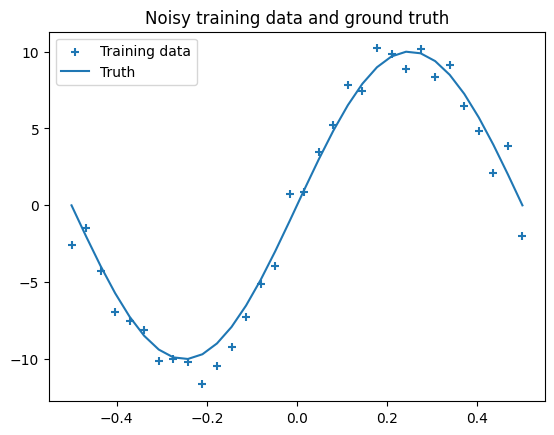

In [ ]:
# generate training data for a simple 1D noisy function

def f(x, sigma):
    epsilon = np.random.randn(*x.shape) * sigma
    return 10 * np.sin(2 * np.pi * (x)) + epsilon

train_size = 32
noise = 1.0

x = np.linspace(-0.5, 0.5, train_size).reshape(-1, 1)
y = f(x, sigma=noise)
y_true = f(x, sigma=0.0)
y_test = f(x, sigma=noise)

x = torch.tensor(x).float()
y = torch.tensor(y).float()
y_test = torch.tensor(y_test).float()
y_true = torch.tensor(y_true).float()

plt.scatter(x.data.numpy(), y.data.numpy(), marker='+', label='Training data')
plt.plot(x.data.numpy(), y_true.data.numpy(), label='Truth')
plt.title('Noisy training data and ground truth')
plt.legend()
plt.show()

In [ ]:
# simple 100 neurons two layer dense NN with bayesian weights with nornmal priors

model = nn.Sequential(
    bnn.BayesLinear(prior_mu=0, prior_sigma=1.5, in_features=1, out_features=20),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=20, out_features=20),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.5, in_features=20, out_features=1),
)

In [ ]:
# loss is the sum of a recontruction loss (MSE) + kl_weight*KL divergence

mse_loss = nn.MSELoss()
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)

# weight of the KL term in the total loss
kl_weight = 1.0

# adam optimiser
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [ ]:
# training loop

training_steps = 1500

for step in range(training_steps):
    pre = model(x)
    mse = mse_loss(pre, y)
    kl = kl_loss(model)
    cost = mse + kl_weight*kl

    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

print('- MSE : %2.2f, KL : %2.2f' % (mse.item(), kl.item()))

- MSE : 2.16, KL : 1.98


100%|██████████| 500/500 [00:00<00:00, 1604.86it/s]


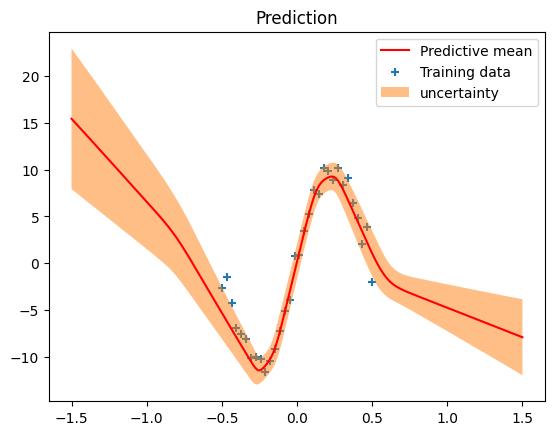

In [ ]:
import tqdm

x_test = np.linspace(-1.5, 1.5, 1000).reshape(-1, 1)
x_test_pt = torch.tensor(x_test).float()
y_pred_list = []

for i in tqdm.tqdm(range(500)):
    y_pred = model(x_test_pt)
    y_pred_list.append(y_pred.data.numpy())

y_preds = np.concatenate(y_pred_list, axis=1)

y_mean = np.mean(y_preds, axis=1)
y_sigma = np.std(y_preds, axis=1)

plt.plot(x_test, y_mean, 'r-', label='Predictive mean');
plt.scatter(x.data.numpy(), y.data.numpy(), marker='+', label='Training data')
plt.fill_between(x_test.ravel(),
                 y_mean + 2 * y_sigma,
                 y_mean - 2 * y_sigma,
                 alpha=0.5, label='uncertainty')
plt.title('Prediction')
plt.legend();